### Guidelines

1. Download our sample dataset
2. Run parallel representation
3. Run AFRN
4. Get visualization

#### 1 Download sample dataset

In this step, you can download our sample data for distress dataset.

The original dataset is './sample_data/textagon_sample/raw.txt'

Files other than the original dataset file are the outputs of parallel representations

In [ ]:
import pandas as pd
from textagon.textagon import Textagon
from textagon.AFRN import AFRN

df = pd.read_csv(
    "sample_data/distress_raw.txt", 
    sep="\t",     
    header=None, 
    names=["classLabels", "corpus"]
)


/home/lalor/.cache/pypoetry/virtualenvs/textagon-mUT4rrjR-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/lalor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lalor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/lalor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/lalor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


current time:- 2025-03-24 09:52:46.353929


#### 2. Run parallel representation


In [3]:

tgon = Textagon(
    inputFile=df, 
    outputFileName="distress",
    maxCores=10
)

tgon.RunFeatureConstruction()
tgon.RunPostFeatureConstruction()

# Spellchecker Details #
Provider: <Enchant: Aspell Provider>
Enchant Version: 2.3.3
Dictionary Tag: en
Dictionary Location: /usr/lib/x86_64-linux-gnu/enchant-2/enchant_aspell.so
Total Exclusions: 0 (No File Supplied)

# CPU Cores Detected and Initialized: 10 #

# Python Details #
3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:31:09) [GCC 11.2.0] 

# Package Versions #
SpaCy: 3.7.5
PyEnchant: 3.2.2
pywsd: 1.2.4
NLTK: 3.9.1 

# Custom Lexicons Imported: 10 #
- ADR (4 Tags)
- AILEXCAT (81 Tags)
- AILEXINT (24 Tags)
- EMOLEX (102 Tags)
- GLOVECC (500 Tags)
- GLOVETW (500 Tags)
- GLOVEWG (500 Tags)
- LIWC (64 Tags)
- SAVLEX (158 Tags)
- SYN (500 Tags)

# Now Reading Raw Data #
Items to Process: 10 

# Now Processing Text Items # 

# Performing Basic Text Cleanup #



100%|██████████| 1/1 [00:05<00:00,  5.37s/it]



Items Processed: 10 (Time Elapsed: 0 days 00:00:05)

### Stage execution finished at 2025-03-24 09:53 AM EDT (Time Elapsed: 0 days 00:00:22) ###

# Now Reading Raw Data #

# Now Reading Feature Data Pickle #
- Time Elapsed: 0 days 00:00:00

# Now Writing Spellchecked Sentences to Disk #
- Time Elapsed: 0 days 00:00:00

# Now Writing Spelling Corrections to Disk #
- Time Elapsed: 0 days 00:00:00

# Now Generating VADER Scores #
- Time Elapsed: 0 days 00:00:00

# Now Constructing Feature Vectors # 

# Settings #
Minimum Term Frequency: 3
N-grams: 4
Requested Feature Vectors: ['binary', 'charbinary']

# Adding Legomena Feature #



  0%|          | 0/1 [00:00<?, ?it/s]/home/lalor/code/textagon/textagon/utils.py:279: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for word in item[0].split(' '):
100%|██████████| 1/1 [00:00<00:00, 130.51it/s]




# Final Set of Feature Representations (10 Total) #
['Affect', 'Boundaries', 'Hypernym', 'Legomena', 'LexiconADR', 'LexiconAILEXCAT', 'LexiconAILEXINT', 'LexiconEMOLEX', 'LexiconGLOVECC', 'LexiconGLOVETW', 'LexiconGLOVEWG', 'LexiconLIWC', 'LexiconSAVLEX', 'LexiconSYN', 'Misspelling', 'MisspellingDetailed', 'NER', 'POS', 'Sentiment', 'Word', 'Word&NER', 'Word&POS', 'Word&Sense'] 

# Now Writing Representations to Disk #
- Time Elapsed: 0 days 00:00:00

# Now Generating Feature Matrices # 

---
Affect
Features: 58 (Time Elapsed: 0 days 00:00:00)
---
Boundaries
Features: 14 (Time Elapsed: 0 days 00:00:00)
---
Hypernym
Features: 59 (Time Elapsed: 0 days 00:00:00)
---
Legomena
Features: 164 (Time Elapsed: 0 days 00:00:00)
---
LexiconADR
Features: 61 (Time Elapsed: 0 days 00:00:00)
---
LexiconAILEXCAT
Features: 67 (Time Elapsed: 0 days 00:00:00)
---
LexiconAILEXINT
Features: 68 (Time Elapsed: 0 days 00:00:00)
---
LexiconEMOLEX
Features: 68 (Time Elapsed: 0 days 00:00:00)
---
LexiconGLOVECC

100%|██████████| 25/25 [00:00<00:00, 273.42it/s]

Number of Zero Variance Features Removed: 221 (Time Elapsed: 0 days 00:00:01)




100%|██████████| 23/23 [00:00<00:00, 401.23it/s]


Number of Duplicate Features Removed: 1807 (Time Elapsed: 0 days 00:00:01)

# Now Writing Results to Disk #
- Time Elapsed: 0 days 00:00:00

# Now Generating Column Key Files #
- Time Elapsed: 0 days 00:00:00

Output Dimensions (Rows, Features): (10, 519) 

### Execution finished at 2025-03-24 09:53 AM EDT (Time Elapsed: 0 days 00:00:24) ###



To run parallel representation, run the commend line above.

Then unzip the representations zip file. In this case, it's named as "distress_representations.zip"

#### 3. Run AFRN

In [4]:

featuresFile = './output/distress_key.txt'
trainFile = './output/distress.csv'
weightFile = './output/distress_weights.txt'


afrn=AFRN(
	featuresFile=featuresFile,
	trainFile=trainFile,
	weightFile=weightFile
)

afrn.RankRepresentations()

Loading features
0 NA
1 BINARY
2 CHARBINARY
Total categories found =  3
Total features found =  519
Total lexicons =  0
Loading training data
Classes= 2 1 0 Num Instances =  10
Number of features in Features file and Train file are different!!! 518 519
Loading sentiment scores 4763
Loading lexicons...
NumLex =  0 NumLexItems =  0
Assigning training weights
Adding semantic weights
0...

Running within-category subsumption relations
Subsuming category  1  of  3 NA
Subsuming category  2  of  3 BINARY
Subsuming category  3  of  3 CHARBINARY
Running cross-category subsumption relations
Running parallel relations


## Next Step

Now, having generated and scored our parallel representations, we can apply them for our downstream tasks.
In this sheet, we will look at informativeness. 

In [5]:
'''This is for regular parallel analysis'''

# Initialize empty lists to hold the data
labels = []
categories = []
counts = []

with open(f'./output/distress_key.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            labels.append(fields[3])
            categories.append('1-' + fields[2])

# Open the weights.txt file and read the data
with open(f'./output/distress_weights.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            # labels.append(fields[0])
            counts.append(fields[3])

# Write the data to the output_key_FRN.txt file
with open(f'./output/distress_key_FRN.txt', 'w') as f:
    # No header as per your requirement
    for label, category, count in zip(labels, categories, counts):
        f.write(f'{label}\t{category}\t{count}')


In [6]:
'''This is for GBS parallel analysis'''

# open files
with open(f'./output/distress_key_GBS.txt', 'r') as output_file, open(f'./output/distress_weights.txt', 'r') as weights_file:
    output_lines = output_file.readlines()
    weights_lines = weights_file.readlines()

# prepare data to write
data_to_write = []

# loop over output lines
for i, output_line in enumerate(output_lines):
    output_line_parts = output_line.strip().split('\t')
    weights_line_parts = weights_lines[i].strip().split('\t')
    
    # Get data from both files
    first_column = output_line_parts[-1]
    second_column = output_line_parts[0]
    third_column = output_line_parts[1]
    fourth_column = weights_line_parts[-1]
    
    # Create a new line with the required format and append it to the list
    new_line = '\t'.join([first_column, second_column, third_column, fourth_column])
    data_to_write.append(new_line)

# write data to new file
with open(f'./output/distress_weights_GBS.txt', 'w') as weights_gbs_file:
    weights_gbs_file.write('\n'.join(data_to_write))


Next, we define some helper functions for running our tGBS.

In [7]:
import datetime 

def analyzeParallel(catStr, category, dfNodes):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[dfNodes['catstring'].str.fullmatch(category)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
            except:
                retToke+=1
    return totToke, retToke

def analyzeParallelGBS(catStr, category, dfNodes, threshold):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[(dfNodes['catstring'].str.fullmatch(category)) & (dfNodes['weight']>threshold)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
            except:
                retToke+=1
    return totToke, retToke


In [9]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = './output/distress_representations.zip'

# Specify the directory to extract files to
extract_to_directory = './output/distress_representations'

# Ensure the directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")


Files extracted to ./output/distress_representations


In [10]:
import numpy as np

#Load DFs and concatenate weights...from GBS
threshold = 0.0000000001

lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./output/'

feature_path = folder_path + 'distress_key_FRN.txt'
dfFeat = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfFeat.columns = ['label', 'category', 'count']
dfFeat['catstring'] = dfFeat.category.str[2:]
dfFeat.set_index(['label', 'category'])

#load GBS weighted version
feature_path = folder_path + 'distress_weights_GBS.txt'
dfWeight = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfWeight.columns = ['featnum','label', 'category', 'weight']
dfWeight['catstring'] = dfWeight.category.str[2:]
dfWeight.set_index(['label', 'category'])

#concatenate
dfResult = pd.merge(dfFeat, dfWeight, how="right", on=["label", "category"], suffixes=('', '_y'))
dfResult.drop(dfResult.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
dfNodes = dfResult[dfResult['category'].str.contains('1-')]

for count, value in enumerate(lstCatsUse):
    OutputFile = open(f"{folder_path}{value}_result.csv","a",encoding='utf8')
    stats = np.zeros((len(lstCatsUse),2))
    rep = folder_path + 'distress_representations/' + 'distress_representation_' + value + '.txt'
    stats[count][0], stats[count][1] = analyzeParallelGBS(rep, value.upper(),dfNodes, threshold)
    OutputFile.write(value+","+str(count)+","+value+","+str(stats[count][0])+","+str(stats[count][1])+","+str(float(stats[count][1]/stats[count][0]))+"\n")
    np.savetxt(f"{folder_path}/Stats.csv", stats, delimiter=",")
    OutputFile.close()

./output/distress_representations/distress_representation_Word.txt 34
./output/distress_representations/distress_representation_Word.txt 0 09:58:25.719878
./output/distress_representations/distress_representation_Word&Sense.txt 0
./output/distress_representations/distress_representation_Word&Sense.txt 0 09:58:25.784303
./output/distress_representations/distress_representation_Word&POS.txt 0
./output/distress_representations/distress_representation_Word&POS.txt 0 09:58:25.826500
./output/distress_representations/distress_representation_Word&NER.txt 0
./output/distress_representations/distress_representation_Word&NER.txt 0 09:58:25.872152
./output/distress_representations/distress_representation_Hypernym.txt 8
./output/distress_representations/distress_representation_Hypernym.txt 0 09:58:25.908915
./output/distress_representations/distress_representation_NER.txt 1
./output/distress_representations/distress_representation_NER.txt 0 09:58:25.962156
./output/distress_representations/distres

In [11]:
lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./output/'

target_file = 'result_GBS.csv'
for file in lstCatsUse:
    with open(f'{folder_path}{file}_result.csv', 'r') as f:
        lines = f.readlines()
    with open(f'{folder_path}{target_file}', 'a') as f:
        for line in lines:
            f.write(line)

#### 4. Get visualization

In [15]:
import os
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import six
import re
import nltk
from nltk.corpus import words

/tmp/ipykernel_15330/420605190.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)


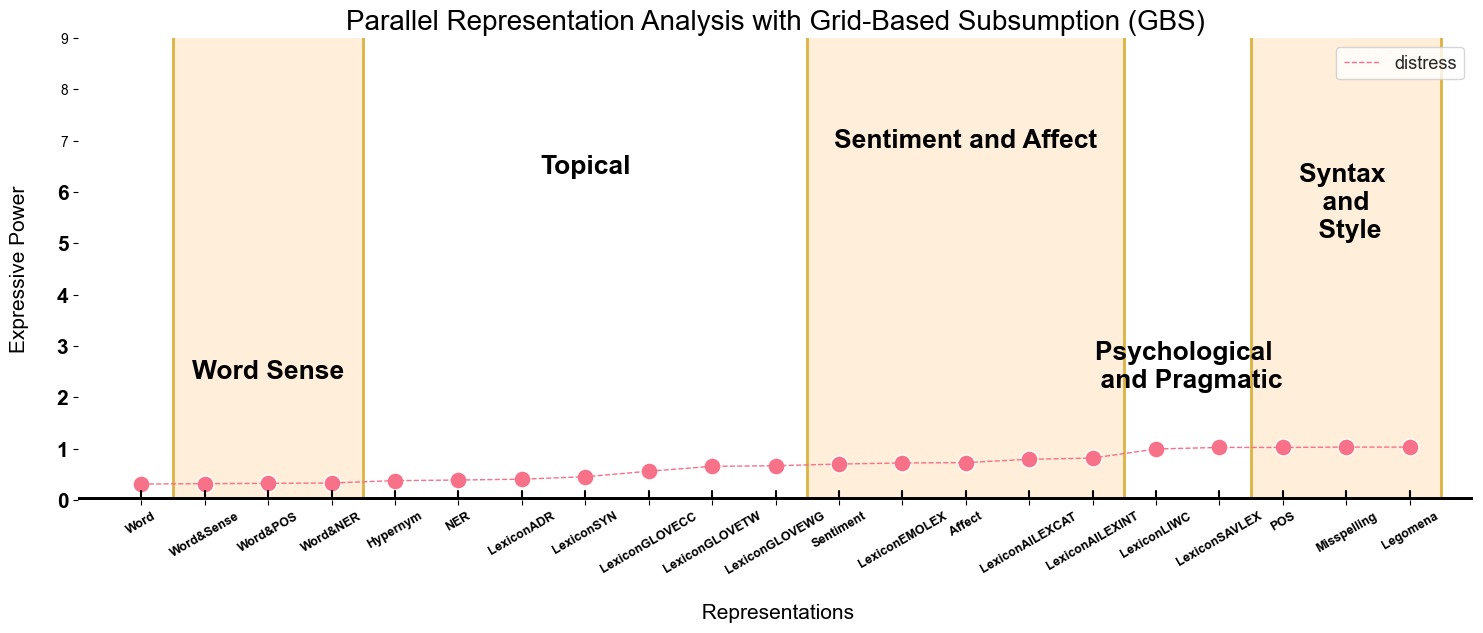

In [16]:
### Set the parameters ###
textagon_output_folder = folder_path
data_name = 'distress'
analysis_output_addr = './'

if 'result_GBS.csv' not in os.listdir(textagon_output_folder):
    raise ValueError(f'The result file is not in the folder: {textagon_output_folder}')

correct_data = []
column_names = ["Path", "Index", "Category", "Total", "Number", "Ratio"]
df = pd.read_csv(f'{textagon_output_folder}/result_GBS.csv', names=column_names)
category_ratio_dict = df.set_index('Category')['Ratio'].to_dict()
c = 0
for key in category_ratio_dict.keys():
    c += category_ratio_dict[key]
    category_ratio_dict[key] = c
correct_data.append(category_ratio_dict)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import re

x_axis = ['Word', 'Word&Sense', 'Word&POS', 'Word&NER', 'Hypernym', 'NER', 'LexiconADR', 'LexiconSYN', 'LexiconGLOVECC', 'LexiconGLOVETW', 'LexiconGLOVEWG', 'Sentiment', 'LexiconEMOLEX', 'Affect', 'LexiconAILEXCAT', 'LexiconAILEXINT', 'LexiconLIWC', 'LexiconSAVLEX', 'POS', 'Misspelling', 'Legomena']

fig, ax = plt.subplots(figsize=(18, 6)) 
line_styles = [ '--', '-.']

def plot_data(data, label, linestyle, linewidth, color):
    sorted_data = {k: data[k] if k in data else 0 for k in x_axis}
    sns.lineplot(x=x_axis, y=list(sorted_data.values()), sort=False, linewidth=linewidth, linestyle=linestyle, ax=ax, label=data_name, color=color)
    sns.scatterplot(x=x_axis, y=list(sorted_data.values()), s=150, ax=ax, color=color)

highlighted_label = 'FCE/ASAP Human/ChatGPT'
# palette = sns.color_palette(['#9236f5', '#3ea4ed', '#20ab5c', '#e38c22'])
palette = sns.color_palette("husl", len(correct_data))
palette = [color for color in palette if not np.allclose(color, (1.0, 0.0, 0.0))]
# palette = sns.color_palette("husl", len(correct_data))

for i, data in enumerate(correct_data):
    # if legend_names[i] == highlighted_label:
    #     plot_data(data, legend_names[i], '-', 4.5, 'red')
    # else:
    plot_data(data, data_name, line_styles[i % len(line_styles)], (i % 3) + 1, palette[i % len(palette)])

ax.legend()

rectangle_1 = patches.Rectangle((0.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_1.set_clip_on(False)
plt.axvline(0.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(3.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_1)

rectangle_2 = patches.Rectangle((10.5, 0), 5, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_2.set_clip_on(False)
plt.axvline(10.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(15.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_2)

rectangle_3 = patches.Rectangle((17.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_3.set_clip_on(False)
plt.axvline(17.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(20.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_3)

plt.text(2, 2.5, 'Word Sense', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(7, 6.5, 'Topical', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(13, 7, 'Sentiment and Affect', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(16.5, 2.6, 'Psychological \n and Pragmatic', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(19, 5.8, 'Syntax \n and \n Style', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')

plt.axhline(0, color='black', linewidth=5, zorder=1)
plt.xticks(rotation=45, weight='bold', fontsize=15)
plt.yticks(weight='bold', fontsize=15)

sns.despine(top=True, right=True, left=True, bottom=True)
sns.set_style("whitegrid")
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.linestyle': '--'})
ax.xaxis.grid(False)
ax.set_ylim(0, 9)
ax.legend(fontsize=13)
ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)

def add_ticks_for_labels():
    for i, _ in enumerate(x_axis):
        ax.axvline(i, 0, 0.02, color='black')  # Here, 0.02 defines the length of the tick relative to y-axis
add_ticks_for_labels() 

plt.xlabel("\n Representations", fontsize=15)
plt.ylabel("Expressive Power\n", fontsize=15)
plt.title("Parallel Representation Analysis with Grid-Based Subsumption (GBS)", fontsize=20)

plt.savefig(f'{analysis_output_addr}/GBS_{data_name}.pdf', bbox_inches='tight')

plt.show()
